In [ ]:
# | default_exp utils/timesteps

# Imports

In [ ]:
# | export


from typing import Literal

import torch
from torch import nn

from vision_architectures.layers.embeddings import (  # noqa: F401
    get_all_timestep_embeddings_1d,
    get_timestep_embeddings_1d,
)

In [ ]:
from matplotlib import pyplot as plt

from vision_architectures.schedulers.noise import CosineNoiseScheduler

# Sampler

In [ ]:
# | export


class TimestepSampler(nn.Module):
    """Sampel timesteps using a strategy.

    Args:
        total_timesteps: Total number of timesteps.
        strategy: Sampling strategy.
        gamma_alpha: Used when strategy == gamma. Alpha parameter for the gamma distribution.
        gamma_spread: Used when strategy == gamma. Controls how spread out the distribution is.
        signal_to_noise_ratios: Used when strategy == importance. Signal-to-noise ratios of the noise schedule.
        temperature: Used when strategy == importance. Temperature for the softmax distribution.
    """

    def __init__(
        self,
        total_timesteps: int,
        strategy: Literal["uniform", "gamma", "importance"],
        gamma_alpha: float = 1.0,
        gamma_spread: float = 0.8,
        signal_to_noise_ratios: torch.Tensor = None,
        temperature: float = 2.0,
    ):
        super().__init__()

        self.T = total_timesteps
        self.strategy = strategy

        if strategy == "uniform":
            # Sample uniformly from [1, T]
            self.distribution = torch.distributions.Uniform(1, self.T + 1)
        elif strategy == "gamma":
            raise NotImplementedError("This implementation still needs to be completeed.")
            # Sample from a gamma distribution. There is no point in parameterizing beta as the sample is normalized
            self.gamma_spread = gamma_spread
            self.distribution = torch.distributions.Gamma(gamma_alpha, 1)
        elif strategy == "importance":
            raise NotImplementedError("This implementation still needs to be completeed.")
            # Sample from [0, T] where prob(t) is d(log(SNR))/dt and prob(t=0) = 0
            if signal_to_noise_ratios is None:
                raise ValueError("signal_to_noise_ratios must be provided for importance sampling.")

            self.snr = signal_to_noise_ratios
            self.log_snr = torch.log(signal_to_noise_ratios)
            self.log_snr_gradient = torch.abs(self.log_snr[1:] - self.log_snr[:-1])
            self.log_snr_gradient = torch.cat(
                [
                    torch.zeros(
                        1,
                    ),
                    self.log_snr_gradient[0:1],
                    self.log_snr_gradient,
                ],
                dim=0,
            )
            self.weights = self.log_snr_gradient ** (1 / temperature)
            self.distribution = torch.distributions.Categorical(probs=self.weights)
        else:
            raise NotImplementedError(f"Sampling strategy {strategy} not implemented.")

    def forward(self, num_timesteps: int):
        """Sample timesteps based on the specified strategy.

        Args:
            num_timesteps: Number of timesteps to sample.
        """
        timesteps = self.distribution.sample((num_timesteps,))
        if self.strategy == "gamma":
            timesteps = timesteps**self.gamma_spread
            timesteps = timesteps / timesteps.max()
            timesteps = timesteps * self.T
        timesteps = timesteps.clamp(1, self.T).long()
        return timesteps

tensor([344, 841, 799, 803, 367, 413, 578, 803, 349, 704])


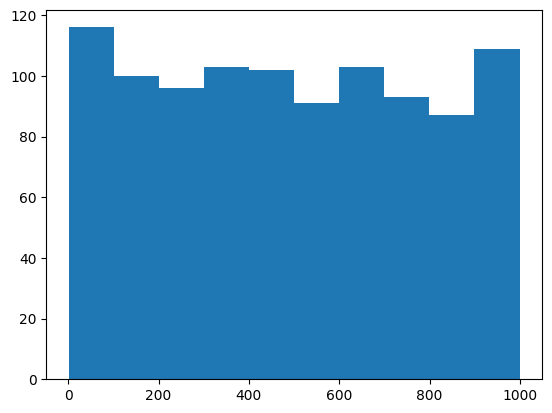

In [ ]:
test = TimestepSampler(1000, "uniform")
print(test(10))

timesteps = test(1000)
plt.hist(timesteps)
plt.show()

In [ ]:
test = TimestepSampler(1000, "gamma")
print(test(10))

timesteps = test(1000)
plt.hist(timesteps, bins=100)
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 test = TimestepSampler(1000, "gamma")                                                        │
│   2 print(test(10))                                                                              │
│   3                                                                                              │
│   4 timesteps = test(1000)                                                                       │
│                                                                                                  │
│ in __init__:34                                                                                   │
│                                                                                                  │
│   31 │   │   │   # Sample uniformly from [1, T]                                                  │
│   32 │   │   │   self.distribution = torch.distributions.Uniform(1, self.T + 1)                  │
│   33 │   │   elif strategy == "gamma":                                                           │
│ ❱ 34 │   │   │   raise NotImplementedError('This implementation still needs to be completeed.    │
│   35 │   │   │   # Sample from a gamma distribution. There is no point in parameterizing beta    │
│   36 │   │   │   self.gamma_spread = gamma_spread                                                │
│   37 │   │   │   self.distribution = torch.distributions.Gamma(gamma_alpha, 1)                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NotImplementedError: This implementation still needs to be completeed.

In [ ]:
T = 1000
scheduler = CosineNoiseScheduler(T)
test = TimestepSampler(
    T, "importance", signal_to_noise_ratios=scheduler.get_snr(torch.linspace(1, T, T, dtype=torch.long))
)
print(test(10))

timesteps = test(T)
plt.hist(timesteps, bins=100)
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 T = 1000                                                                                    │
│    2 scheduler = CosineNoiseScheduler(T)                                                         │
│ ❱  3 test = TimestepSampler(                                                                     │
│    4 │   T, "importance", signal_to_noise_ratios=scheduler.get_snr(torch.linspace(1, T, T, dt    │
│    5 )                                                                                           │
│    6 print(test(10))                                                                             │
│                                                                                                  │
│ in __init__:39                                                                                   │
│                                                                                                  │
│   36 │   │   │   self.gamma_spread = gamma_spread                                                │
│   37 │   │   │   self.distribution = torch.distributions.Gamma(gamma_alpha, 1)                   │
│   38 │   │   elif strategy == "importance":                                                      │
│ ❱ 39 │   │   │   raise NotImplementedError('This implementation still needs to be completeed.    │
│   40 │   │   │   # Sample from [0, T] where prob(t) is d(log(SNR))/dt and prob(t=0) = 0          │
│   41 │   │   │   if signal_to_noise_ratios is None:                                              │
│   42 │   │   │   │   raise ValueError("signal_to_noise_ratios must be provided for importance    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NotImplementedError: This implementation still needs to be completeed.

# nbdev

In [ ]:
!nbdev_export